In [1]:
import faiss

In [2]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [3]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [4]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = r"C:\Users\mruna\Downloads\img_highres\input_Images"
filenames = sorted(get_file_list(root_dir))

In [5]:
import glob
img_lst = []
image_paths = glob.glob(r"C:\Users\mruna\Downloads\img_highres\input_Images\*.jpg")
for image_path in image_paths:
    img_lst.append(image_path)

In [6]:
#Sampling the dataset, as the program takes a lot of time to run
imglist = img_lst[:500]

In [7]:
feature_list = []
for i in tqdm(range(len(imglist))):
    feature_list.append(extract_features(imglist[i], model))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.27it/s]


In [8]:
features=np.array(feature_list)
features.shape

(500, 100352)

In [9]:

dimensions=features.shape[1]
db_vectors=features 
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [10]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)

False
0
True
500


In [11]:
nprobe = 1  # find 2 most similar clusters
n_query = 1000  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(features, k)

In [12]:
distances

array([[0.        , 0.5797259 , 0.6128618 , ..., 0.69319737, 0.69840896,
        0.70505387],
       [0.        , 0.5755225 , 0.7420691 , ..., 0.8393694 , 0.8541    ,
        0.85766596],
       [0.        , 0.46171927, 0.6506249 , ..., 0.75746787, 0.7636671 ,
        0.7645181 ],
       ...,
       [0.        , 0.9791495 , 0.9836704 , ..., 1.0874437 , 1.0969118 ,
        1.1267222 ],
       [0.        , 0.45599204, 0.7401261 , ..., 1.0768206 , 1.0805649 ,
        1.086     ],
       [0.        , 0.54316163, 0.7401261 , ..., 1.0576656 , 1.0771706 ,
        1.0810549 ]], dtype=float32)

In [13]:
indices

array([[  0, 322, 255, ...,  65, 197, 271],
       [  1, 323, 270, ..., 194,  94, 296],
       [  2, 324,   6, ..., 246, 313,  73],
       ...,
       [497, 495, 496, ..., 373, 411, 350],
       [498, 495, 499, ..., 423, 351, 382],
       [499, 496, 498, ..., 398, 494, 351]], dtype=int64)

In [14]:
def faiss_similarity(img):
    feature_list=extract_features(r'C:/Users/mruna/Downloads/img_highres/input_Images/'+str(img), model)
    nprobe = 2  # find 2 most similar clusters
    n_query = 1  
    k = 10  # return 10 nearest neighbours
    np.random.seed(0)
    dimensions=len(feature_list)   
    query_vectors = np.random.random((n_query, dimensions)).astype('float32')
    distances, indices = index.search(feature_list.reshape(1,-1), k)
    list_ind=indices.flatten().tolist()
    f, ax = plt.subplots(1, 10, figsize=(16, 8))
    for i,j in enumerate(list_ind):
        ax[i].imshow(plt.imread(imglist[j]))
        ax[i].set_axis_off()
    plt.show()

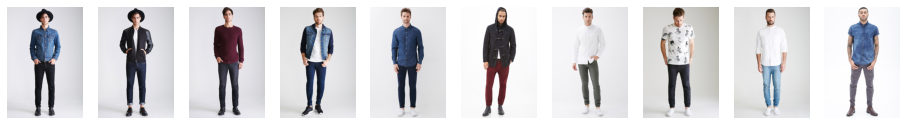

In [15]:
faiss_similarity('MEN_Denim_id_0000195201_7_additional.jpg') #278,72

In [16]:
imglist2 = []
for i in range(len(imglist)):
    imglist2.append(imglist[i])
print(len(imglist2))
print(imglist2)

500
['C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_1_front.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_2_side.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_3_back.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_7_additional.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_1_front.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_2_side.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_3_back.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_7_additional.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008902_1_front.jpg', 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008902_2_side.jpg', 'C:\\Users\\mruna\\Downloads\\img_highre

In [17]:
df_img = pd.DataFrame()
df_img['img'] = imglist2
df_img

,img
0,C:\Users\mruna\Downloads\img_highres\input_Ima...
1,C:\Users\mruna\Downloads\img_highres\input_Ima...
2,C:\Users\mruna\Downloads\img_highres\input_Ima...
3,C:\Users\mruna\Downloads\img_highres\input_Ima...
4,C:\Users\mruna\Downloads\img_highres\input_Ima...
...,...
495,C:\Users\mruna\Downloads\img_highres\input_Ima...
496,C:\Users\mruna\Downloads\img_highres\input_Ima...
497,C:\Users\mruna\Downloads\img_highres\input_Ima...
498,C:\Users\mruna\Downloads\img_highres\input_Ima...


In [18]:
df_indices = pd.DataFrame(indices)
imgref = df_img.to_dict()
imgref = imgref['img']
imgref

{0: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_1_front.jpg',
 1: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_2_side.jpg',
 2: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_3_back.jpg',
 3: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008001_7_additional.jpg',
 4: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_1_front.jpg',
 5: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_2_side.jpg',
 6: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_3_back.jpg',
 7: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008901_7_additional.jpg',
 8: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008902_1_front.jpg',
 9: 'C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000008902_2_side.jpg',
 10: 

In [19]:
df_indices = df_indices.replace(imgref)
df_indices

,0,1,2,3,4,5,6,7,8,9
0,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
1,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
2,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
3,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
4,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
...,...,...,...,...,...,...,...,...,...,...
495,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
496,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
497,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mrun

In [20]:
df_indices.to_csv(r'C:\Users\mruna\Downloads\img_highres\Faiss.csv')

In [21]:
# Artistic

In [22]:
pip install bson

Note: you may need to restart the kernel to use updated packages.


In [23]:
from tqdm import tqdm

import glob
import ntpath
import cv2

from sklearn.metrics.pairwise import cosine_similarity
import scipy as sc
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model

import io
import bson
import matplotlib.pyplot as plt
from skimage.io import imread   # or, whatever image library you prefer
import multiprocessing as mp      # will come in handy due to the size of the data
from PIL import Image

In [24]:
import glob
image_paths = glob.glob(r'C:\Users\mruna\Downloads\img_highres\input_Images\*.jpg')

In [25]:
images = {}
for image_path in image_paths:
    image = cv2.imread(image_path, 3)
    b,g,r = cv2.split(image)           # Splitting the RGB Channels of the image
    image = cv2.merge([r,g,b]) 
    image = cv2.resize(image, (200, 200))
    images[image_path] = image

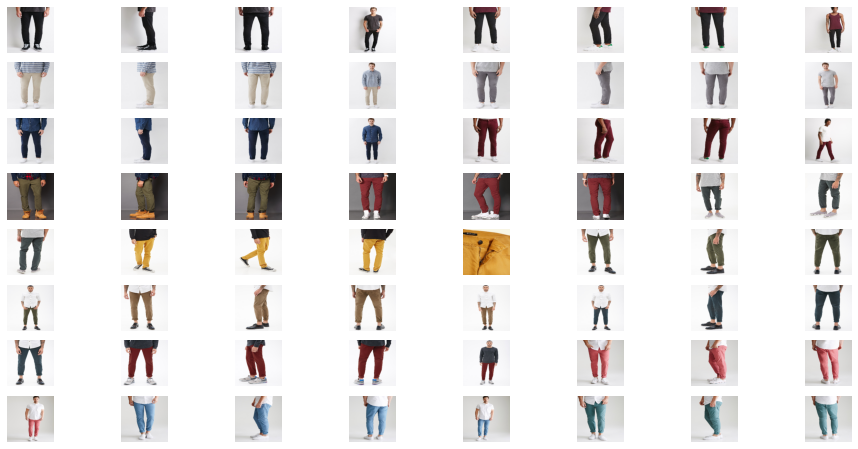

In [26]:
n_col = 8
n_row = 8
f, ax = plt.subplots(n_row, n_col, figsize=(16, 8))
for i in range(n_row):
    for j in range(n_col):
        ax[i, j].imshow(list(images.values())[n_col*i + j])
        ax[i, j].set_axis_off()

In [27]:
def load_image(image):
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, [400, 400])
    img = img[tf.newaxis, :] # shape -> (batch_size, h, w, d)
    return img

# content layers describe the image subject
content_layers = ['block5_conv2'] 

# style layers describe the image style
# we exclude the upper level layes to focus on small-size style details
style_layers = [ 
        'block1_conv1',
        'block2_conv1',
        'block3_conv1', 
        #'block4_conv1', 
        #'block5_conv1'
    ] 

def selected_layers_model(layer_names, baseline_model):
    outputs = [baseline_model.get_layer(name).output for name in layer_names]
    model = Model([vgg.input], outputs)
    return model

# style embedding is computed as concatenation of gram matrices of the style layers
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

class StyleModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleModel, self).__init__()
        self.vgg =  selected_layers_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        # scale back the pixel values
        inputs = inputs*255.0
        # preprocess them with respect to VGG19 stats
        preprocessed_input = preprocess_input(inputs)
        # pass through the reduced network
        outputs = self.vgg(preprocessed_input)
        # segregate the style and content representations
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # calculate the gram matrix for each layer
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # assign the content representation and gram matrix in
        # a layer by layer fashion in dicts
        content_dict = {content_name:value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

def image_to_style(image_tensor):
    extractor = StyleModel(style_layers, content_layers)
    return extractor(image_tensor)['style']

def style_to_vec(style):
    # concatenate gram matrics in a flat vector
    return np.hstack([np.ravel(s) for s in style.values()]) 
    
# compute styles
image_style_embeddings = {}
for image_path in tqdm(image_paths[:500] ):
    image_tensor = load_image(image_path)
    style = style_to_vec( image_to_style(image_tensor) )
    image_style_embeddings[image_path] = style

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [05:23<00:00,  1.54it/s]


In [28]:
def search_by_style_display(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    
    f, ax = plt.subplots(1, max_results, figsize=(16, 8))
    for i, img in enumerate(sorted_neighbors[:max_results]):
        ax[i].imshow(images[img[0]])
        ax[i].set_axis_off()
    
    plt.show()

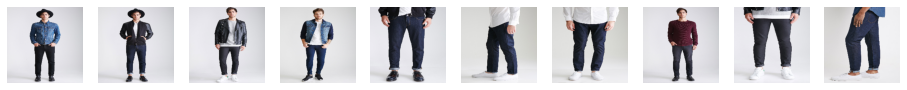

In [34]:
search_by_style_display(r'C:\Users\mruna\Downloads\img_highres\input_Images\MEN_Denim_id_0000195201_7_additional.jpg') #227,72

In [35]:
def search_by_style(reference_image, max_results=10):
    v0 = image_style_embeddings[reference_image]
    distances = {}
    for k,v in image_style_embeddings.items():
        d = sc.spatial.distance.cosine(v0, v)
        distances[k] = d

    sorted_neighbors = sorted(distances.items(), key=lambda x: x[1], reverse=False)
    return sorted_neighbors[:11]

In [36]:
search_by_style(r'C:\Users\mruna\Downloads\img_highres\input_Images\MEN_Denim_id_0000195201_7_additional.jpg')

[('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000195201_7_additional.jpg',
  0),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000035301_7_additional.jpg',
  0.0077620744705200195),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000520801_7_additional.jpg',
  0.010795354843139648),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000635901_7_additional.jpg',
  0.01118546724319458),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000035301_1_front.jpg',
  0.011821508407592773),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000572401_2_side.jpg',
  0.013368546962738037),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000572401_1_front.jpg',
  0.01419687271118164),
 ('C:\\Users\\mruna\\Downloads\\img_highres\\input_Images\\MEN_Denim_id_0000537801_7_additional.jpg',
  0.014366567134857178),
 ('C:\\Users\\mruna\

In [37]:
x = []
for image_name in tqdm(images.keys()):
    z = search_by_style(image_name)
    x.append(z)
    #print(len(x))
    if len(x) == 500:
      break

  1%|▊                                                                           | 499/45359 [04:07<6:10:27,  2.02it/s]


In [38]:
y = pd.DataFrame(x)
y

,0,1,2,3,4,5,6,7,8,9,10
0,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
1,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
2,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
3,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
4,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
...,...,...,...,...,...,...,...,...,...,...,...
495,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
496,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Users\mruna\Downloads\img_highres\input_Im...
497,(C:\Users\mruna\Downloads\img_highres\input_Im...,(C:\Us

In [39]:
def test(neigh):
  return neigh[0]

In [40]:
z = y.applymap(test)
z

,0,1,2,3,4,5,6,7,8,9,10
0,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
1,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
2,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
3,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
4,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
...,...,...,...,...,...,...,...,...,...,...,...
495,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
496,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Users\mruna\Downloads\img_highres\input_Ima...
497,C:\Users\mruna\Downloads\img_highres\input_Ima...,C:\Use

In [41]:
z.to_csv(r'C:/Users/mruna/Downloads/img_highres/Artistic.csv')